In [ ]:
import cv2
import csv

# Load video
video = cv2.VideoCapture("S6160005.mp4")  # Replace with the path to your video file

# Check if video loaded successfully
if not video.isOpened():
    print("Error: Could not open video.")
    exit()

# Read the first frame
success, frame = video.read()
if not success:
    print("Error: Could not read video.")
    exit()

# Select two ROIs manually for two objects
bbox1 = cv2.selectROI("Select Object 1", frame, False)
bbox2 = cv2.selectROI("Select Object 2", frame, False)
cv2.destroyWindow("Select Object 1")
cv2.destroyWindow("Select Object 2")

# Initialize trackers for each object
tracker1 = cv2.TrackerCSRT_create()
tracker2 = cv2.TrackerCSRT_create()
tracker1.init(frame, bbox1)
tracker2.init(frame, bbox2)

# Lists to store coordinates for each object
coords_obj1 = []
coords_obj2 = []

# Tracking loop
frame_count = 0
while True:
    # Read a new frame
    success, frame = video.read()
    if not success:
        print("End of video or cannot fetch the frame.")
        break

    # Process every 10th frame only
    if frame_count % 10 == 0:
        # Update the first tracker and draw its bounding box
        success1, bbox1 = tracker1.update(frame)
        if success1:
            (x1, y1, w1, h1) = [int(v) for v in bbox1]
            cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 0), 2)
            cv2.putText(frame, "Object 1", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            coords_obj1.append((x1, y1))  # Store coordinates
        else:
            coords_obj1.append((None, None))  # Append None if tracking failed
            cv2.putText(frame, "Object 1 Lost", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

        # Update the second tracker and draw its bounding box
        success2, bbox2 = tracker2.update(frame)
        if success2:
            (x2, y2, w2, h2) = [int(v) for v in bbox2]
            cv2.rectangle(frame, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 2)
            cv2.putText(frame, "Object 2", (x2, y2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            coords_obj2.append((x2, y2))  # Store coordinates
        else:
            coords_obj2.append((None, None))  # Append None if tracking failed
            cv2.putText(frame, "Object 2 Lost", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

        # Display the frame with tracked objects
        cv2.imshow("Two-Object Tracking", frame)

    # Increment the frame count
    frame_count += 1

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

# Export to CSV
with open("object_tracking_coordinates.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Frame", "Object 1 X", "Object 1 Y", "Object 2 X", "Object 2 Y"])
    for i, (coord1, coord2) in enumerate(zip(coords_obj1, coords_obj2)):
        writer.writerow([i * 10, coord1[0], coord1[1], coord2[0], coord2[1]])

print("Coordinates saved to object_tracking_coordinates.csv")

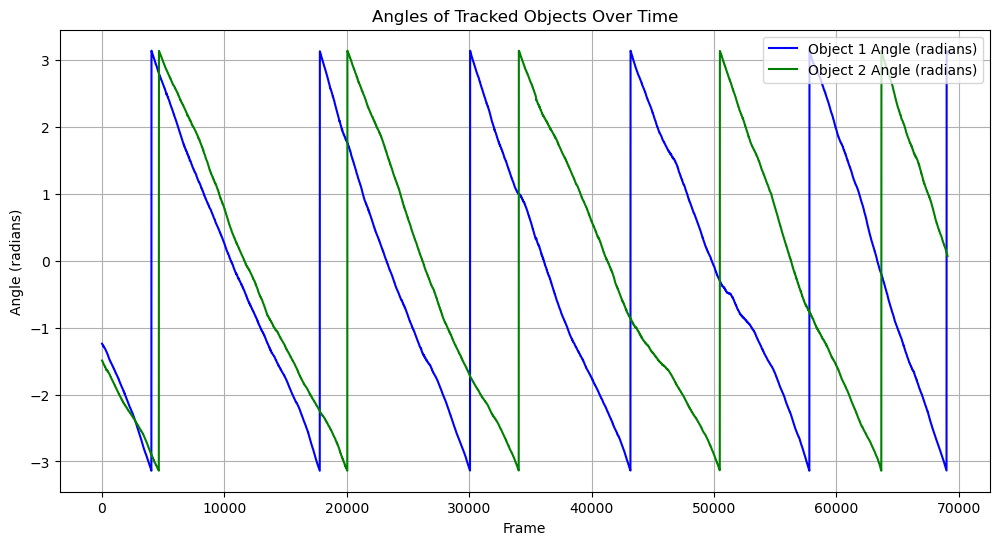

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Define the centers of circular motion for the objects
center_obj1 = (594, 460)  # Replace with actual center coordinates for object 1
center_obj2 = (1329, 460)  # Replace with actual center coordinates for object 2

# Lists to store calculated angles
angles_obj1 = []
angles_obj2 = []
frames = []

# Read CSV file
with open("object_tracking_coordinates.csv", mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Skip header

    for row in reader:
        frame = int(row[0])
        x1, y1 = (row[1], row[2])
        x2, y2 = (row[3], row[4])

        # Append frame number for x-axis
        frames.append(frame)

        # Calculate angle for object 1 if coordinates are valid
        if x1 != 'None' and y1 != 'None':
            x1, y1 = float(x1), float(y1)
            angle1 = np.arctan2(y1 - center_obj1[1], x1 - center_obj1[0])
            angles_obj1.append(angle1)
        else:
            angles_obj1.append(None)

        # Calculate angle for object 2 if coordinates are valid
        if x2 != 'None' and y2 != 'None':
            x2, y2 = float(x2), float(y2)
            angle2 = np.arctan2(y2 - center_obj2[1], x2 - center_obj2[0])
            angles_obj2.append(angle2)
        else:
            angles_obj2.append(None)

# Plot angles
plt.figure(figsize=(12, 6))
plt.plot(frames, angles_obj1, label="Object 1 Angle (radians)", color="blue")
plt.plot(frames, angles_obj2, label="Object 2 Angle (radians)", color="green")
plt.xlabel("Frame")
plt.ylabel("Angle (radians)")
plt.title("Angles of Tracked Objects Over Time")
plt.legend()
plt.grid(True)
plt.show()
